# Customer Segmentation
GitHub location: https://github.com/LarsTinnefeld/olist_ecom_analysis.git

This project is part of a larger Olist ecommerce business analysis and is the capstone project for the Udacity Data Science Nanodegree Program.

![logo](https://i2.wp.com/dataneophyte.com/wp-content/uploads/2019/12/Logo-01.png?resize=513%2C401&ssl=1)

## Questions to answer
1. What is the demographic relationship between customers?
2. Is there a geological correlation to customer characteristics?
3. Can we draw conclusions from RFM segmentation?
4. Can we develop a model to recommend how to target customer groups?
---
## Table of Contents

I. [Data Import and Wrangling](#data)<br>
II. [Exploratory Analysis](#eda)<br>
III. [Customer Segmentation](#segmentation)<br>
IV. [Geodemographic Segmentation](#geosegmentation)<br>
V. [RFM Analysis](#rfm)<br>
VI. [K Means Clustering](#k_means)<br>
VII. [Evaluation](#evaluation)<br>
VIII. [Conclusion](#conclusion)

---
## <a class="anchor" id="data">I. Data Import and Wrangling</a>

### 1. Libraries

In [79]:
import pandas as pd
import numpy as np

from datetime import datetime as dt
from datetime import timedelta
import re
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pywaffle import Waffle

import plotly as py
import plotly.offline as offline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout
from plotly import tools

init_notebook_mode(connected=True)
%matplotlib inline

### 2. Importing data

Data structure:

<img src="https://i.imgur.com/HRhd2Y0.png" width="700" height="450">

### Customer data

In [80]:
# Customer lookup table
df_customer = pd.read_csv("../0 - data/olist_customers_dataset.csv")

In [81]:
# Taking a peek
df_customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [82]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


This looks like a complete dataset. Doublecheck:

In [83]:
df_customer.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [84]:
# Finding duplicates
df_customer.duplicated().sum()

0

### Order data

In [85]:
df_orders = pd.read_csv('../0 - data/df_orders_consolidated.csv')

In [86]:
df_orders.head()

,Unnamed: 0,Unnamed: 0.1,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_line_cube_in_ltr,price_round,customer_unique_id
0,0,0,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-11-09,2016-10-20,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,b7d76e111c89f7ebf14761390f0f7d17
1,1,1,35d3a51724a47ef1d0b89911e39cc4ff,27ab53f26192510ff85872aeb3759dcc,delivered,2016-10-04,2016-10-05,2016-10-14,2016-10-26,2016-12-20,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,f922896769e9517ea3c630f3c8de86d0
2,2,2,c4f710df20f7d1500da1aef81a993f65,4b671f05b6eb9dc1d2c1bae9c8c78536,delivered,2016-10-10,2016-10-10,2016-10-18,2016-10-26,2016-12-14,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,0ecf7f65b5ff3b9e61b637e59f495e0a
3,3,3,81e5043198a44ddeb226002ff55d8ad4,ddd15ef77c83eea8c534d2896173a927,delivered,2017-01-09,2017-01-09,2017-01-09,2017-02-24,2017-02-24,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,10.752,40.0,853ba75a0b423722ccf270eea3b4cfe4
4,4,4,03b218d39c422c250f389120c531b61f,db857a86c685a6a3a02a705961ec1ff1,delivered,2017-01-14,2017-01-14,2017-01-16,2017-01-18,2017-03-01,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,c83d504c46170342ddbc93c762e0e4ec


In [87]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102425 entries, 0 to 102424
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     102425 non-null  int64  
 1   Unnamed: 0.1                   102425 non-null  int64  
 2   order_id                       102425 non-null  object 
 3   customer_id                    102425 non-null  object 
 4   order_status                   102425 non-null  object 
 5   order_purchase_timestamp       102425 non-null  object 
 6   order_approved_at              102425 non-null  object 
 7   order_delivered_carrier_date   102425 non-null  object 
 8   order_delivered_customer_date  102425 non-null  object 
 9   order_estimated_delivery_date  102425 non-null  object 
 10  order_time                     102425 non-null  object 
 11  delivery_time                  102425 non-null  object 
 12  date_ordinal                  

This is a cleaned data table from previous analysis. All missing values are added, all duplicated entries are removed and order lines were consolidated. We only need to format the date fields into datetime format.

In [88]:
def convert_to_dt(dat, cols):
    '''Function takes in a dataframe name and date columns for conversion into datetime format'''
    for col in cols:
        dat[col] = pd.to_datetime(dat[col]).dt.date

# converting dates to datetime
convert_to_dt(df_orders, [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
    ])

In [89]:
df_orders.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

### Gepgraphic data

In [90]:
df_geolocation = pd.read_csv('../0 - data/olist_geolocation_dataset.csv')

In [91]:
df_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [92]:
df_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [93]:
df_geolocation['geolocation_zip_code_prefix'].value_counts()

24220    1146
24230    1102
38400     965
35500     907
11680     879
         ... 
73990       1
87307       1
72450       1
24877       1
38198       1
Name: geolocation_zip_code_prefix, Length: 19015, dtype: int64

The zip code prefix's are not unique. That means we can not assign look up one distict coordinate for a customer but need to apply an aggregate function. I will use the mean for longitude and latitude. In that way a coordinate is in the middle of the neighbohood with this zip code. The downside is that for visualizations where will be overlapping dots on the with the upper most being the one which is visible. This will be solve this with aggregate functions.

---
## <a class="anchor" id="eda">II. Exploratory Data Analysis</a>
The focus is on getting an understanding about the customers buying habits and their locations.

In [94]:
n_customers = df_customer['customer_unique_id'].nunique()
print('Unique customers: {}'.format(n_customers))
n_cities = df_customer['customer_city'].nunique()
print('Unique cities: {}'.format(n_cities))

Unique customers: 96096
Unique cities: 4119


Where are the customers from?

In [95]:
# City disctribution
df_customer['customer_city'].value_counts().sort_values(ascending=False)

sao paulo                   15540
rio de janeiro               6882
belo horizonte               2773
brasilia                     2131
curitiba                     1521
                            ...  
uniao                           1
aparecida do rio negro          1
campos verdes                   1
vargem grande do soturno        1
correntes                       1
Name: customer_city, Length: 4119, dtype: int64

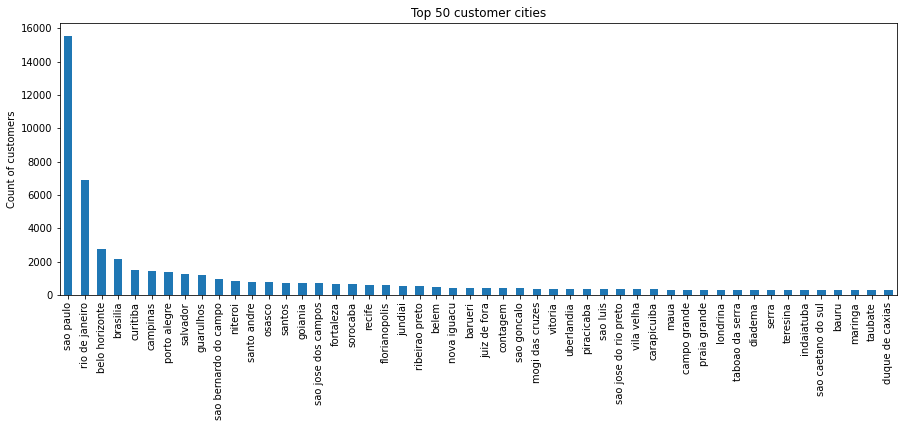

In [96]:
(
    df_customer['customer_city']
    .value_counts()
    .sort_values(ascending=False)
    .head(50)
    .plot(kind='bar', figsize=(15, 5))
)

plt.title('Top 50 customer cities')
plt.ylabel('Count of customers');

The customers come from 4119 different cities, whith Sao Paulo as the city where most of the customers live.

In [97]:
# How many states are the customers from?
df_customer['customer_state'].nunique()

27

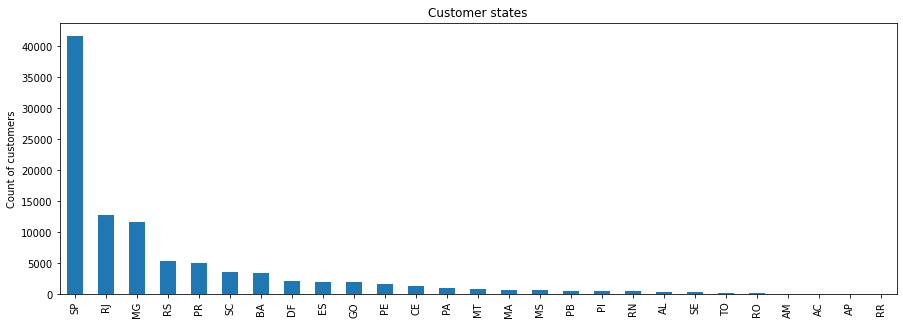

In [98]:
# States disctribution
(
    df_customer['customer_state']
    .value_counts()
    .sort_values(ascending=False)
    .plot(kind='bar', figsize=(15, 5))
)

plt.title('Customer states')
plt.ylabel('Count of customers');

The customers come from 27 different states  whith Sao Paulo as the state where most of the customers live.

In [99]:
# How many zip codes?
df_customer['customer_zip_code_prefix'].nunique()

14994

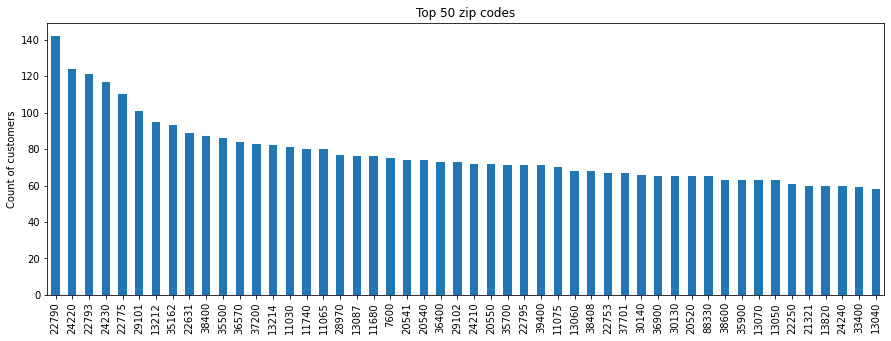

In [100]:
# Top 50 zip codes
(
    df_customer['customer_zip_code_prefix']
    .value_counts()
    .sort_values(ascending=False)
    .head(50)
    .plot(kind='bar', figsize=(15, 5))
    )

plt.title('Top 50 zip codes')
plt.ylabel('Count of customers');

When did new customers placed their first order?

In [101]:
df_customer_dly = df_orders.groupby('customer_unique_id', as_index=False)\
    .agg({'order_purchase_timestamp': 'min'})

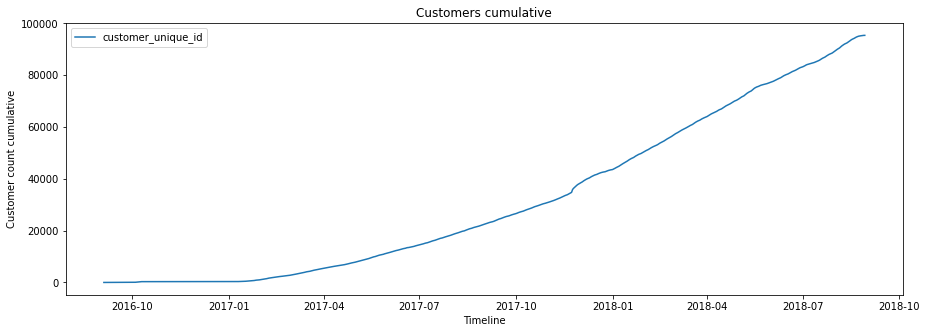

In [102]:
df_customer_dly.groupby('order_purchase_timestamp').count().cumsum().plot(figsize=(15,5))
plt.title('Customers cumulative')
plt.xlabel('Timeline')
plt.ylabel('Customer count cumulative');

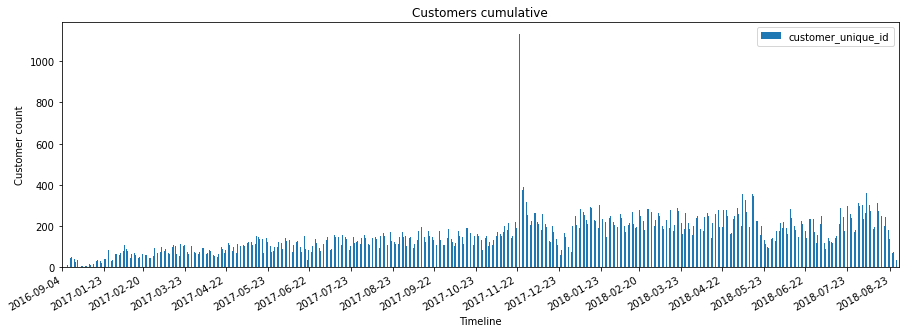

In [103]:
# New customers count by day
ax = df_customer_dly.groupby('order_purchase_timestamp').count().plot(kind='bar', figsize=(15,5))
# set monthly locator
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()
plt.title('Customers cumulative')
plt.xlabel('Timeline')
plt.ylabel('Customer count');

## Conclusion

- Customer come from 4119 cities and 27 states
- Most of the customers live in Sao Paulo by a factor of 2 to the second ranked city, Rio de Janeiro
- Many new cutomers appeared on Black Friday. It is interesting to see that the impact is not very pronounced when looking at the cumulative customer count for the total time span.
- Overall, the increase of customers has an upward trend. The trendline is slightly exponential, which means that the growth is accelerating slowly.

---
## <a class="anchor" id="segmentation">III. Customer Segmentation</a>
The segmentation will classify customers based on their bying frequency, amount of purchases and money spent.

Question to answer:
- How are customers segmented according time of purchase, purchase amount and number of orders?

In [104]:
# Create a work copy
df = df_orders[[
    'customer_unique_id',
    'order_id',
    'order_status',
    'order_purchase_timestamp',
    'product_id',
    'qty',
    'price',
    'product_category_name'
    ]].copy()

We only are interested in customers which completed the interaction (`order_status` = "delivered").

In [105]:
df['order_status'].value_counts()

delivered      100196
shipped          1127
canceled          465
invoiced          322
processing        306
unavailable         7
approved            2
Name: order_status, dtype: int64

In [106]:
df = df[df['order_status']=='delivered']

We will pretend that the last day in the dataset represents the current day. Based on this, we calculate the number of days between the purchase and "Today"

In [107]:
# Setting reference day
df['today'] = df['order_purchase_timestamp'].max()
# Date deltas
df['recency'] = df['today'] - df['order_purchase_timestamp']

In [108]:
# Need to get the total price for an order line
df['total_price'] = df['qty'] * df['price']

In [109]:
# Grouping by customer and order (same order_id = same day); This will be the data frame which contains all valid costomers and how they are segmented
df_segmented_customers = df.groupby([
    'customer_unique_id',
    'order_id'
    ], as_index=False).agg({
        'order_purchase_timestamp': 'first',
        'qty': 'sum',
        'total_price': 'sum',
        'today': 'first',
        'recency': 'first'
        })

In [110]:
df_segmented_customers['recency']\
    = df_segmented_customers['recency'].astype(str)
df_segmented_customers['recency']\
    = df_segmented_customers['recency'].str.replace(r'\s+days.*', '', regex=True)
df_segmented_customers['recency']\
    = df_segmented_customers['recency'].astype(int)

In [111]:
df_segmented_customers = df_segmented_customers\
    .groupby('customer_unique_id', as_index=False)\
    .agg({
        'recency': ['min', 'max', 'count'],
        'total_price': ['sum', 'mean']
        })

In [112]:
# Simplifying columns
df_segmented_customers.columns = [' '.join(col).strip() for col in df_segmented_customers.columns.values]

In [113]:
# Renaming columns
df_segmented_customers.rename(columns={
    'recency max': 'days_since_first_order',
    'recency min': 'recency',
    'recency count': 'frequency',
    'total_price sum': 'total_payment',
    'total_price mean': 'avg_payment'
    }, inplace=True)

In [114]:
# Defining time range conditions for classifying customers
total_time_range = str(df["order_purchase_timestamp"].max() - df["order_purchase_timestamp"].min())
total_time_range

'713 days, 0:00:00'

In [115]:
# Splitting total time range in 4 time periods
period = int(re.sub(r'\s+days.*', '', total_time_range))/4

## Assigning activity clasifications

In [116]:
# activity classes
class_inactive = df_segmented_customers['recency'] > period * 3
class_cold = (df_segmented_customers['recency'] > period * 2)\
    & (df_segmented_customers['recency'] <= period * 3)
class_hot = (df_segmented_customers['recency'] > period)\
    & (df_segmented_customers['recency'] <= period * 2)
class_active = df_segmented_customers['recency'] <= period

In [117]:
# Adding activity classes to dataframe
df_segmented_customers.loc[class_inactive, "segment"] = "inactive"
df_segmented_customers.loc[class_cold, "segment"] = "cold"
df_segmented_customers.loc[class_hot, "segment"] = "hot"
df_segmented_customers.loc[class_active, "segment"] = "active"

In [118]:
# Defining payment range conditions for classifying customers
median_payment = df_segmented_customers['avg_payment'].median()

In [119]:
# Sub classes
class_inactive_low = df_segmented_customers['segment'] == 'inactive'
class_cold_low = (df_segmented_customers['segment'] == 'cold')\
    & (df_segmented_customers['avg_payment'] < median_payment)
class_cold_high = (df_segmented_customers['segment'] == 'cold')\
    & (df_segmented_customers['avg_payment'] >= median_payment)
class_hot_low = (df_segmented_customers['segment'] == 'hot')\
    & (df_segmented_customers['avg_payment'] < median_payment)
class_hot_high = (df_segmented_customers['segment'] == 'hot')\
    & (df_segmented_customers['avg_payment'] >= median_payment)
class_active_low = (df_segmented_customers['segment'] == 'active')\
    & (df_segmented_customers['avg_payment'] < median_payment)
class_active_high = (df_segmented_customers['segment'] == 'active')\
    & (df_segmented_customers['avg_payment'] >= median_payment)

In [120]:
# Adding sub classes to dataframe
df_segmented_customers.loc[class_inactive_low, "sub_segment"] = "inactive"
df_segmented_customers.loc[class_cold_low, "sub_segment"] = "cold_low"
df_segmented_customers.loc[class_cold_high, "sub_segment"] = "cold_high"
df_segmented_customers.loc[class_hot_low, "sub_segment"] = "hot_low"
df_segmented_customers.loc[class_hot_high, "sub_segment"] = "hot_high"
df_segmented_customers.loc[class_active_low, "sub_segment"] = "active_low"
df_segmented_customers.loc[class_active_high, "sub_segment"] = "active_high"

In [121]:
# We can use this color scheme for various visualizations
dict_colors = {
    'inactive': 'midnightblue',
    'cold_low': 'blue',
    'cold_high': 'mediumslateblue',
    'hot_low': 'darkorchid',
    'hot_high': 'magenta',
    'active_low': 'deeppink', 
    'active_high': 'red'
    }

In [122]:
def plot_waffle_chart(metric, agg, title_txt, group='sub_segment'):
    '''
    Funtion to create a waffle chart. The visualization shows how the customer sub-segments are distributed according defined metrics.

    Input:
    - metric - feature/ kpi metric to visualize
    - agg - method to aggregate
    - title_txt - text to display as chart title

    Outout:
    - waffle chart

    '''
    data_revenue = dict(round(df_segmented_customers\
        .groupby(group)\
        .agg({metric: agg}))[metric])

    fig = plt.figure(
        FigureClass=Waffle,
        rows=5,
        columns=10,
        values=data_revenue,
        labels=[f"{k, v}" for k, v in data_revenue.items()],
        legend={'loc': 'lower left', 'bbox_to_anchor': (1, 0)},
        figsize=(8, 5)
        )

    plt.title(title_txt)

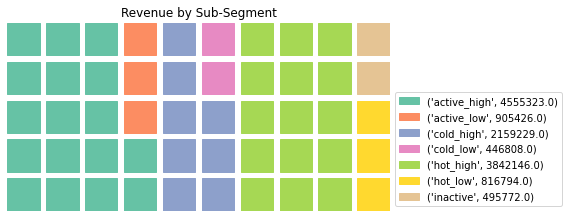

In [123]:
# Total revenue by sub-segment
plot_waffle_chart('total_payment', 'sum', 'Revenue by Sub-Segment')

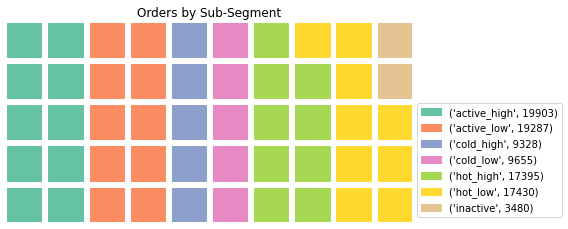

In [124]:
# Total orders placed by sub-segment
plot_waffle_chart('frequency', 'sum', 'Orders by Sub-Segment')

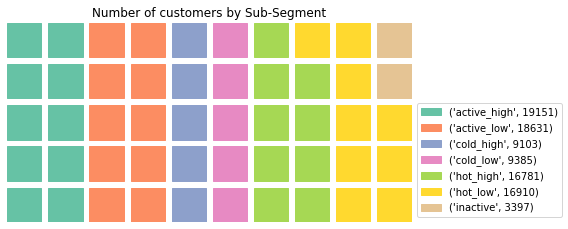

In [125]:
# Number of customers per sub-segment
plot_waffle_chart('customer_unique_id', 'count', 'Number of customers by Sub-Segment')

## Conclusion
How are customers segmented according time of purchase, purchase amount and number of orders?

- The strongest class of the 7 generated sub-segments is active customers with high spending, followed by "hot" customers which high spending, which is a good sign for the business.
- Active customers with high and low spending placed the most orders, followed by "hot" customers.
- Active customers are also the biggest groups in terms of head count.
- Inactive customers represent in each chart the smallest proportion.

This segmentation provides a base to develop a strategy how and if to target customers.

---
## <a class="anchor" id="geosegmentation">IV. Geodemographic Segmentation</a>
In this classification the customers are geographically visualized based on quantitive comparison of multiple characteristics.

Question to answer:
- Is there a geolographical correlation to specific characteristics?

In [126]:
# Making dictionaries to mapp zip code prefix and coordinates to the customers
dict_cust_zip = df_customer.set_index('customer_unique_id').to_dict()['customer_zip_code_prefix']
dict_lat = df_geolocation.set_index('geolocation_zip_code_prefix').to_dict()['geolocation_lat']
dict_lng = df_geolocation.set_index('geolocation_zip_code_prefix').to_dict()['geolocation_lng']

In [127]:
# Adding zip code to df
df_segmented_customers['geolocation_zip_code_prefix']\
    = df_segmented_customers['customer_unique_id'].map(dict_cust_zip)

In [128]:
# Adding coordinates and color code to the dataframe
df_segmented_customers['geolocation_lat']\
    = df_segmented_customers['geolocation_zip_code_prefix'].map(dict_lat)
df_segmented_customers['geolocation_lng']\
    = df_segmented_customers['geolocation_zip_code_prefix'].map(dict_lng)
df_segmented_customers['color']\
    = df_segmented_customers['sub_segment'].map(dict_colors)

In [129]:
# Defining function to plot maps
def plot_map(df, title, lower_bound, upper_bound, metric, sub_segment_y_n=False):
    '''
    Funtion for geographic data visualization of demographic metrics.

    Input:
    - df - dataframe with target feature (metric; color-code field needed if sub_segment to visualize
    - title - text to display as chart title
    - lower_bound - lower threshold for color scale
    - upper_bound - upper threshold for color scale
    - metric - feature/ kpi metric to visualize
    - sub_sement_y_n - boolean, if "True": sub-segment will be visualized with color-code if no, color acording value

    Outout:
    - geographic data visualization

    '''

    if sub_segment_y_n == True:
        dict_marker = dict(
            size = 2,
            color = df.color
            )
    else:
        dict_marker = dict(
            size = 2,
            color = df[metric],
            showscale=True,
            colorscale=[[0, 'blue'],
                        [1, 'red']],
            cmin = lower_bound,
            cmax = upper_bound
            )

    data_geo = [go.Scattermapbox(
        lon = df['geolocation_lng'],
        lat = df['geolocation_lat'],
        marker = dict_marker
        )]
    
    layout = dict(
            title = title,
            showlegend=False,
            mapbox = dict(
                accesstoken = 'pk.eyJ1IjoiaG9vbmtlbmc5MyIsImEiOiJjam43cGhpNng2ZmpxM3JxY3Z4ODl2NWo3In0.SGRvJlToMtgRxw9ZWzPFrA',
                center= dict(lat=-23.5,lon=-46.6),
                bearing=10,
                pitch=0,
                zoom=2,
            )
        )
    fig = dict( data=data_geo, layout=layout )
    iplot( fig, validate=False)

## Geodemographic map of sub-segments
Evaluation how our customer segmentation is located on the map. Because the zip code prefix is not individually assigned to a specific customer and is not the detailed zip code I need to work with: 1) coordinates which are ageraged for a specific neighborhooe and 2) aggregate all metrics for the coordinates (a coordinate can have many customers with different values).

In [130]:
# Because the coordinates of the customers are not unique (explanation in the data import) I need to extract the most common cutomer call (color)
sample_subsegments = df_segmented_customers.groupby(
    'geolocation_zip_code_prefix',
    as_index=False
    ).agg({
        'geolocation_lat': 'first',
        'geolocation_lng': 'first',
        'color': lambda x:x.value_counts().index[0]
        }).sample(n=100)

In [131]:
plot_map(sample_subsegments, 'Geological distribution of customer sub-segments',0, 0, 'n', True)

As expected, the customers are concentrated around the big cities in the east of the country. On the first view, there is not a clear concentration of sub-segments in specific areas. 

## Areas by cumulative revenue

In [132]:
sample_renenue = df_segmented_customers.groupby(
    'geolocation_zip_code_prefix',
    as_index=False
    ).agg({
        'total_payment': 'sum',
        'geolocation_lat': 'first',
        'geolocation_lng': 'first'
        }).sample(n=100)

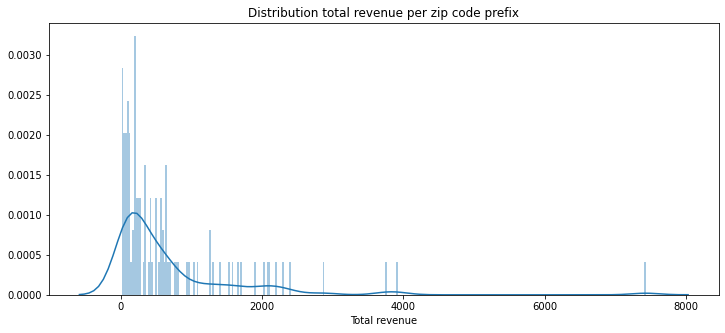

In [133]:
# Distribution of total revenue
plt.figure(figsize=(12, 5))
sns.distplot(sample_renenue['total_payment'], bins=300);
plt.title('Distribution total revenue per zip code prefix')
plt.xlabel('Total revenue');

A big majority of neighborhoods is on the low end of the distribution when looking at the summarized revenue. This can have different reasons: 1) Small group size, 2) Low purchase values, 3) a combination of 1 and 2

In [134]:
plot_map(sample_renenue, 'Cumulative revenue',100 , 3000, 'total_payment', False)

The chart shows that there is some clustering between higher revenue and lower revenue areas, especially if setting the lower bound threshold higher. In neighborhoods of "Campinas" mostly higher total values while in the suburbs "Vila Amelia", "Brasilandia" and "Limao District" mostly lower values dominate. Rio de Janeiro, especially around the waterfront is mostly blue, while the north-western suburbs are mainly red.

We need to be careful with the interpretation here:
- As seen in the EDA section, some zip codes have more customers assigned, so a high total value can be an effect of a big group size

As a refresher, a box chart to display the statistical distribution of the group sizes:

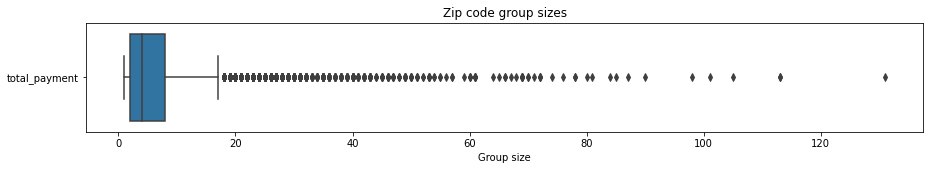

In [135]:
plt.figure(figsize=(15, 2))
sns.boxplot(data=df_segmented_customers.groupby('geolocation_zip_code_prefix').agg({'total_payment': 'count'}), orient='h')

plt.xlabel('Group size')
plt.title('Zip code group sizes');

The distribution of the group sizes is very similar to what we see in the distribution of the total revenue. That means, that neighborhoode with higher revenue have that higher value most likely because of a biger amount of customers within this zip code prefix.

We can do a normalization by dividing the total revenue by the numbers of customers to get a tota revenue per customer for a specific zip code, or in other words: Take the average of the total_payments.

## Distribution of average purchase value
The average purchase price spending is independent of the group size and will tell a bit more about spending behavior of individuals in an area.

In [136]:
sample_avg_spend = df_segmented_customers.groupby(
    'geolocation_zip_code_prefix',
    as_index=False
    ).agg({
        'total_payment': 'mean',
        'geolocation_lat': 'first',
        'geolocation_lng': 'first'
        }).sample(n=100)

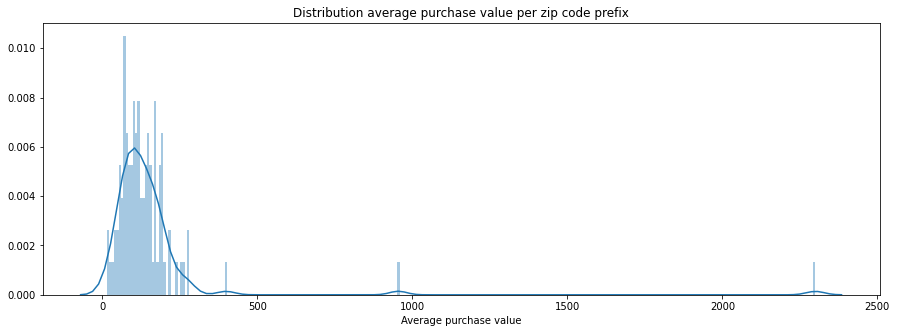

In [137]:
# Distribution of average purchase value
plt.figure(figsize=(15, 5))
sns.distplot(sample_avg_spend['total_payment'], bins=300);
plt.title('Distribution average purchase value per zip code prefix')
plt.xlabel('Average purchase value');

Above shows the average purchase value distribution, averaged over zip codes. It shows a right-skewed curve. The majority of the purchase values is in the range of 100-120. This seems also to be in line with the general product cost distribution (reference EDA analysis in "Olist Business Trend Analysis").

In [138]:
plot_map(sample_avg_spend, 'Average prchase value', 50, 280, 'total_payment', False)

By adjusting the lower- and uppder band of the color scale it can be seen that there's a general tendency of lower purchase prices in the South of Brazil while higher purchase prices are more existing in the North. The effect is not very pronounced but still visible. A significance test to statistically prove that this difference has sufficient evindence would need to be done in case this will be considered important in the final business case.

## First and last order by location
When did new customers appeared where? When and where were the last orders placed?

In [139]:
sample_latest_purch = df_segmented_customers.groupby(
    'geolocation_zip_code_prefix',
    as_index=False
    ).agg({
        'recency': 'mean',
        'geolocation_lat': 'first',
        'geolocation_lng': 'first'
        }).sample(n=100)

sample_avg_newbies = df_segmented_customers.groupby(
    'geolocation_zip_code_prefix',
    as_index=False
    ).agg({
        'days_since_first_order': 'mean',
        'geolocation_lat': 'first',
        'geolocation_lng': 'first'
        }).sample(n=100)

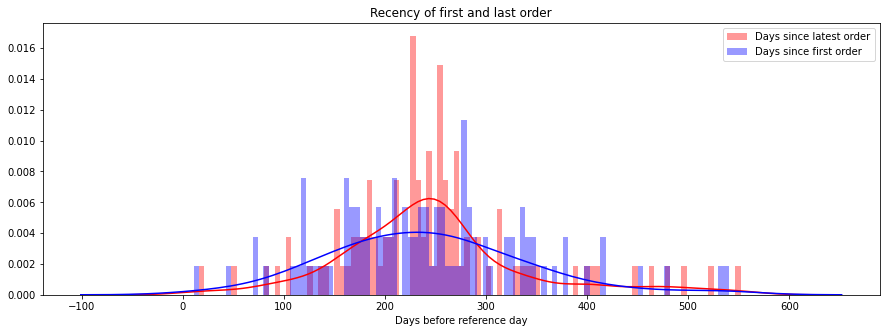

In [140]:
plt.figure(figsize=(15, 5))
sns.distplot(sample_latest_purch['recency'], color='red', bins=100)
sns.distplot(sample_avg_newbies['days_since_first_order'], color='blue', bins=100)

plt.title('Recency of first and last order')
plt.xlabel('Days before reference day')
plt.legend(['Days since latest order', 'Days since first order'])
plt.show();

Most of the orders in general were placed in the range of 200-250 days before "day 0" (our reference day = last order in dataset).

In [141]:
plot_map(sample_avg_newbies, 'First orders',50 ,500 , 'days_since_first_order', False)

There is not a specific geographic dependency to see in the visualization.

## Conclusion

- There is not a clear correlation between location and customer sub-segment to observe
- Some level of clustering in view of higher- and lower total reveny can be seen. This might for a big part be the effect of the group sizes.
- There seem to be a slightly higher spending in the north of Brazil. A statistical test to validate this statement would need to be performed before basing any decisions on this.

---
## <a class="anchor" id="rfm">V. RFM Analysis</a>
The RFM analysis segments customers based on three metrics:
- Recency
- Frequency
- Monetary

Question to answer:
- How does RFM modeling impact the picture?
- What conclusions can we draw?

### Generating the dataframe
All the information we need is already existing in the dataframe we prepared for the customer segmentation (`df_segmented_customers`), so we can skip this step.

### Recency

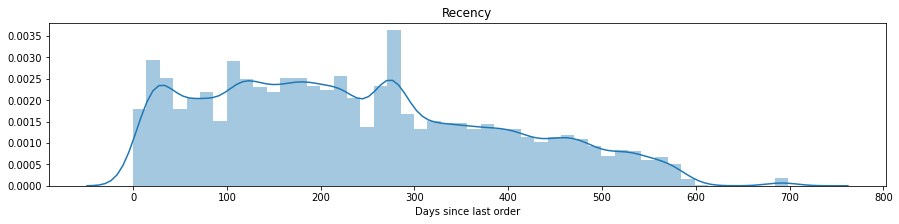

In [142]:
plt.figure(figsize=(15, 3))
sns.distplot(df_segmented_customers['recency'])

plt.xlabel('Days since last order')
plt.title('Recency');

This chart makes sense because we see that there is the spike at round about 270 days before the reference day. That falls in the time period of the heavy Black Friday sales event where a lot of customers placed their latest order.

### Frequency

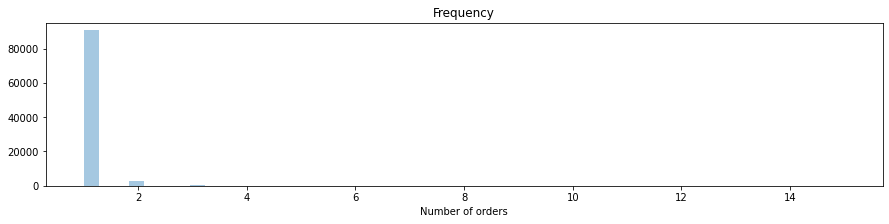

In [143]:
plt.figure(figsize=(15, 3))
sns.distplot(df_segmented_customers['frequency'], kde=False);

plt.xlabel('Number of orders')
plt.title('Frequency');

We have seen this chart before. There are many customers which only placed one order. As hinted in the initial "Olist Business Trend Analysi", the error which many will likely get trapped is by simply applying `count of order_id` during grouping by customer_unique_id. Reason why this leads to a wrong result:
- Quantity in the original order table is created by number of rows (order quantity = 4 means 4 rows of data)
- Two SKUs (products) means two separate rows in the data table

=> If we group by user "X" whose order contains procuct "A" with quantity 2 and procuct "B" with quantity 1, we will get 3 as count for this customer while in reality only one single order was placed.

### Monetary

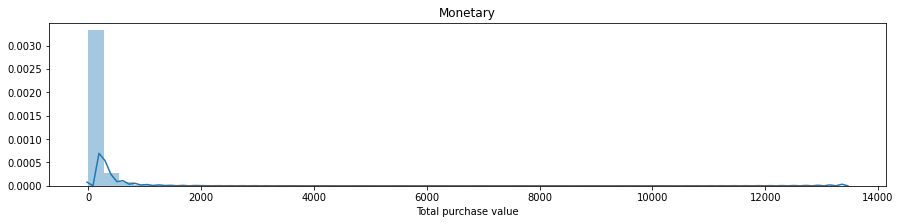

In [144]:
plt.figure(figsize=(15, 3))
sns.distplot(df_segmented_customers['total_payment']);

plt.xlabel('Total purchase value')
plt.title('Monetary');

In [145]:
# Frequencies:
df_segmented_customers['frequency'].unique()

array([ 1,  2,  3,  4,  6,  7,  5,  9, 15], dtype=int64)

In [146]:
def assign_frequency(x):
    '''
    Function to assign frequency score

    Input:
    - x - order placed, integer

    Output:
    - F - frequency score
    '''
    
    if x >= 7:
        return 4
    elif x >= 4:
        return 3
    elif x >= 2:
        return 2
    else:
        return 1

In [147]:
# Distribute values to quartiles (for 4 segments) and add to dataframe
df_segmented_customers['R'] =\
    pd.qcut(df_segmented_customers['recency'], q=4, labels=range(4, 0, -1))
df_segmented_customers['F'] =\
    df_segmented_customers['frequency'].apply(assign_frequency)
df_segmented_customers['M'] =\
    pd.qcut(df_segmented_customers['total_payment'], q=4, labels=range(1, 5))
df_segmented_customers.head()

,customer_unique_id,recency,days_since_first_order,frequency,total_payment,avg_payment,segment,sub_segment,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,color,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,111,111,1,129.90,129.90,active,active_high,7787,-23.353375,-46.824556,red,4,1,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,114,1,18.90,18.90,active,active_low,6053,-23.559455,-46.789721,deeppink,4,1,1
2,0000f46a3911fa3c0805444483337064,537,537,1,69.00,69.00,inactive,inactive,88115,-27.535895,-48.630935,midnightblue,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,321,321,1,25.99,25.99,hot,hot_low,66812,-1.307324,-48.481083,darkorchid,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,288,288,1,180.00,180.00,hot,hot_high,18040,-23.508786,-47.462823,magenta,2,1,4


I now need to label the RFM combination and calculate the RFM score.

In [148]:
# Define- and assign label to dataframe
df_segmented_customers['segment_RFM']\
    = df_segmented_customers['R'].astype(str)\
    + df_segmented_customers['F'].astype(str)\
    + df_segmented_customers['M'].astype(str)
df_segmented_customers['score_rfm'] = df_segmented_customers[['R','F','M']].sum(axis=1)

In [149]:
# These are the customer RFM segments with the appropriate approach suggestion
dict_rfm_tiers = {'Best customer': 'Personalized communication, offer loyalty program, no promotional offers needed', 'Big Spender': 'Make them feel valued and offer quality products, encourage to stick with brands', 'Loyalist': 'Offer loyalty program', 'Potential Loyalists': 'Recommend products and offer discounts', 'Almost Lost': 'Try to win them with limited sales promotions', 'Hibernating': 'Make great offers with big discounts', 'Lost Customer': 'Do not spent much effort and money to win them'}

In [150]:
def rfm_assiner(df):
    '''
    Function to assign RFM classes according conditions.

    Input:
    - df - dataframe containing RFM score and RFM segment key

    Output:
    - returns a RFM segment class (str)
    '''
    if (int(df['segment_RFM']) >= 434) or (df['score_rfm'] >= 9):
        return 'Best customer'
    elif (df['score_rfm'] >= 8) and (df['M'] == 4):
        return 'Big Spender'
    elif (df['score_rfm'] >= 6) and (df['F'] >= 2):
        return 'Loyalist'
    elif (int(df['segment_RFM']) >= 231) or (df['score_rfm'] >= 6):
        return 'Potential Loyalists'
    elif ((int(df['segment_RFM']) >= 121) and (df['R'] == 1)) or df['score_rfm'] == 5:
        return 'Almost Lost'
    elif (df['score_rfm'] >= 4) and (df['R'] == 1):
        return 'Hibernating'
    else:
        return 'Lost Customer'

In [151]:
df_segmented_customers['customer_rfm_segment']\
    = df_segmented_customers.apply(rfm_assiner, axis=1)

In [152]:
df_segmented_customers['marketing_approach']\
    = df_segmented_customers['customer_rfm_segment'].apply(lambda x: dict_rfm_tiers[x])

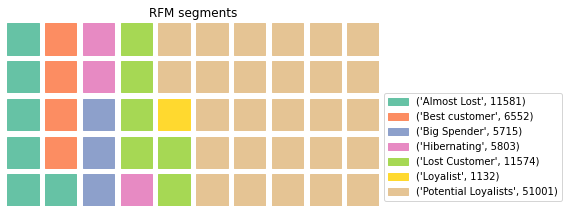

In [153]:
# Vizualize segment sizes with the waffe chart
plot_waffle_chart('customer_unique_id', 'count', 'RFM segments', 'customer_rfm_segment')

In [154]:
# Make a clean table for presentation
df_tbl_rfm = df_segmented_customers.groupby('customer_rfm_segment').agg(
    Count = ('customer_unique_id', 'count'),
    Recency = ('recency', 'mean'),
    Frequency = ('frequency', 'mean'),
    Monetary = ('total_payment', 'mean'),
    Strategy = ('marketing_approach', 'unique'),
).round(1)
df_tbl_rfm

,Count,Recency,Frequency,Monetary,Strategy
customer_rfm_segment,,,,,
Almost Lost,11581,360.9,1.0,88.8,[Try to win them with limited sales promotions]
Best customer,6552,66.6,1.2,356.4,"[Personalized communication, offer loyalty pro..."
Big Spender,5715,172.9,1.1,346.3,[Make them feel valued and offer quality produ...
Hibernating,5803,446.5,1.0,64.8,[Make great offers with big discounts]
Lost Customer,11574,367.6,1.0,29.0,[Do not spent much effort and money to win them]
Loyalist,1132,290.9,2.1,173.4,[Offer loyalty program]
Potential Loyalists,51001,184.2,1.0,136.7,[Recommend products and offer discounts]


## Conclusion

- The order frequency and order amounts are concentrated on the lower end. This is what we have repeatedly have seen before.
- The biggest RFM segment is the group of `Potential Loyalists`. These are customers that need to be targeted with offers and discounts in order to make the business successful.
- There is a good base of `Best Customers`, which is good news for the business.
- Some effort needs to be spent to target `hibernating` customers and customers which are `almost lost`

---
## <a class="k_means" id="rfm">VI. K Means Clustering</a>

...

In [155]:
df_segmented_customers.head()

,customer_unique_id,recency,days_since_first_order,frequency,total_payment,avg_payment,segment,sub_segment,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,color,R,F,M,segment_RFM,score_rfm,customer_rfm_segment,marketing_approach
0,0000366f3b9a7992bf8c76cfdf3221e2,111,111,1,129.90,129.90,active,active_high,7787,-23.353375,-46.824556,red,4,1,3,413,8.0,Potential Loyalists,Recommend products and offer discounts
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,114,1,18.90,18.90,active,active_low,6053,-23.559455,-46.789721,deeppink,4,1,1,411,6.0,Potential Loyalists,Recommend products and offer discounts
2,0000f46a3911fa3c0805444483337064,537,537,1,69.00,69.00,inactive,inactive,88115,-27.535895,-48.630935,midnightblue,1,1,2,112,4.0,Hibernating,Make great offers with big discounts
3,0000f6ccb0745a6a4b88665a16c9f078,321,321,1,25.99,25.99,hot,hot_low,66812,-1.307324,-48.481083,darkorchid,2,1,1,211,4.0,Lost Customer,Do not spent much effort and money to win them
4,0004aac84e0df4da2b147fca70cf8255,288,288,1,180.00,180.00,hot,hot_high,18040,-23.508786,-47.462823,magenta,2,1,4,214,7.0,Potential Loyalists,Recommend products and offer discounts


In [156]:
# import plotly.graph_objects as go
# import numpy as np

# Helix equation
# t = np.linspace(0, 20, 100)
# x, y, z = np.cos(t), np.sin(t), t

#x = df_segmented_customers['recency']
#y = df_segmented_customers[df_segmented_customers['frequency']<6]['frequency']
#z = df_segmented_customers[df_segmented_customers['total_payment']<4000]['total_payment']


#fig = go.Figure(data=[go.Scatter3d(
#    x=x,
#    y=y,
#    z=z,
#    mode='markers',
#    marker=dict(
#        size=2,
#        color=z,                # set color to an array/list of desired values
#        colorscale='Viridis',   # choose a colorscale
#        opacity=0.8
#    )
#)])

# tight layout
#fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
#fig.show()

In [158]:
x

0        111
1        114
2        537
3        321
4        288
        ... 
93353    447
93354    262
93355    568
93356    119
93357    484
Name: recency, Length: 93358, dtype: int32

In [164]:
#plt.scatter(x='recency', y='total_payment', data=df_segmented_customers)